# Robustness analysis on the flood model

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs

from numpy.linalg import inv

In [2]:
import utils.truncated_Gaussians as trGauss
import utils.truncated_Gumbel as trGumb
import utils.truncated_Triangular as trTriang

"""These modules contain the main functions that will be useful for applying the robustness analysis method"""

'This modules contain the main functions that will be useful for applying the robustness analysis method'

The flood model is defined as 

$$H:= G(Q,K,Z_m,Z_v) = \left( \frac{Q}{300K \sqrt{\frac{Z_m - Z_v}{5000}}}\right)^{0.6}$$

where $Q$ is a truncated Gumbel, $K$ is a truncated normal variable and $Z_m$ and $Z_v$ are triangular distributions.

In [5]:
# We define the function G

def G(Q,K,Zm,Zv):
    D = 300*K*np.sqrt((Zm-Zv)/5000)
    return (Q/D)**0.6

# iid sample from each variables' baseline distribution
    
    #sample size
N = 10000

    # initial parameters on input distributions
th0_Gumb = np.array([1013,558]) 
th0_Gauss = np.array([30,7.5])
th0_Zm = 55
th0_Zv = 50

    # truncation interval for each input
a_Q,b_Q = 0,3000
a_K,b_K = 15,90
a_Zm,b_Zm = 54,56
a_Zv,b_Zv = 49,51

    #sample
Q_sample = trGumb.sample(th0_Gumb[0],th0_Gumb[1],N,a_Q,b_Q)
K_sample = trGauss.sample(th0_Gauss[0],th0_Gauss[0],N,a_K,b_K)
Zm_sample = trTriang.sample(th0_Zm,N,a_Zm,b_Zm)
Zv_sample = trTriang.sample(th0_Zv,N,a_Zv,b_Zv)

    #output of G on the input samples
H_val = G(Q_sample,K_sample,Zm_sample,Zv_sample)

## 1. Choosing $\delta_\max$ and some other parameters

In [6]:
delta_max = 1
alpha = 0.9

# number of discretization points on each concentric sphere
nb_pts = 100

# number of concentric spheres
nb_sphere = 10

#step size in the Euler method for solving geodesics
h = 0.01

## 2. Computation of spheres on which the quantile will be optimized

We now discretize the spheres with radius $\delta_{\max}$ (the outermost sphere) using the functions tracer_sphere_tr_avec_geod from the modules trGauss and trGumb for the truncated Gaussian and Gumbel variables. For the triangular variables, we use the functions spheres_exact to compute the only two points on each spheres.

In [7]:
start = timeit.default_timer()

# For K, truncated Gaussian variable
n_Gauss,C_sph_Gauss,Liste_Gauss_tr_sph = trGauss.tracer_sphere_tr_avec_geod(th0_Gauss,delta_max,nb_pts,h,a_K,b_K)

# For Q, truncated Gumbel variable
n_Gumb,C_sph_Gumb,Liste_Gumb_tr_sph = trGumb.tracer_sphere_tr_avec_geod_Gumb(th0_Gumb,delta_max,nb_pts,h,a_Q,b_Q)

#For Zm, triangular variable
Triang_sphere_Zm = [ trTriang.spheres_exact(th0_Zm,delta,a_Zm,b_Zm) for delta in np.linspace(0.1,1.1,nb_sphere)]

#For Zv, triangular variable
Triang_sphere_Zv = [ trTriang.spheres_exact(th0_Zv,delta,a_Zv,b_Zv) for delta in np.linspace(0.1,1.1,nb_sphere)]

stop = timeit.default_timer()

print(np.floor(stop-start)/60," minutes")

13.866666666666667  minutes


The previous functions only return the discretized points on the outermost sphere for the two-parameter families (Gaussian and Gumbel) i.e. the sphere with radius $\delta_{\max}$, along with the geodesics that end up on these points. The following helper function uses these geodesics to build the concentric spheres. It returns a list where each element is itself an array of points on the same concentric sphere.

In [8]:
def concentric_spheres(Liste_geod,n,nb_spheres):
    """Helper function for building the concentric spheres
    
    Liste_geod (list): Contains the list of geodesics starting from the same point
    n (int): number of steps in the geodesic approximation (it corresponds to Tf/h where h is 
    the step size and Tf is the final time for the geodesic)
    nb_spheres (int): number of spheres
    
    output: array where each element is a collection of discretized points on a concentric sphere"""
    
    liste_de_spheres_pt = []
    for i in range(1,nb_spheres+1):
        k=int(n*i/nb_spheres)-1
        XXk = [X[k] for X in Liste_geod[:,0]]
        YYk = [Y[k] for Y in Liste_geod[:,1]]
        liste_de_spheres_pt.append(np.array([XXk,YYk]))
        
    return np.array(liste_de_spheres_pt)

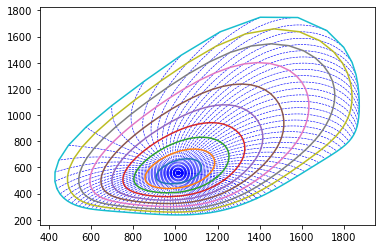

In [9]:
# Draws geodesics going from the center of the sphere in dotted lines for the Gumbel family
for i in range(nb_pts):
    X= Liste_Gumb_tr_sph[i][0]
    Y= Liste_Gumb_tr_sph[i][1]
    plt.plot(X,Y,color="blue",ls='--',linewidth = 0.6)

# Draws the concentric spheres in solid lines
l = concentric_spheres(Liste_Gumb_tr_sph,n_Gumb,nb_sphere+1)
for i in range(1,nb_sphere):
    plt.plot(l[i][0],l[i][1])
plt.plot(C_sph_Gumb[:,0],C_sph_Gumb[:,1])

In [76]:
# Converting the list of geodesics going from the center to a list where each element is itself a list of 
# points on the same concentric sphere. This uses the function concentric_spheres defined previously.

Conctr_Gauss_sph = concentric_spheres(Liste_Gauss_tr_sph,n_Gauss,nb_sphere)
Conctr_Gumb_sph = concentric_spheres(Liste_Gumb_tr_sph,n_Gumb,nb_sphere)
Conctr_TriangZm_sph = Triang_sphere_Zm 
Conctr_TriangZv_sph = Triang_sphere_Zv

## 3. Three dimensional plots of concentric spheres and graph of quantile estimators

In [13]:
# computing the quantile estimator on geodesic spheres (after perturbation) of the gaussian and gumbel inputs
start0 = timeit.default_timer()

quant_Gauss_val_sur_sph = []
print("Computation started at time = ...")
print("Computing the quantile estimator for perturbations of K")
for i in range(nb_sphere):
    Quant_Gauss = [trGauss.quantile_estim_fast(trGauss.F_is,K_sample,H_val,th0_Gauss,th,alpha,a_K,b_K) 
                   for th in Conctr_Gauss_sph[i].transpose()]
    quant_Gauss_val_sur_sph.append(Quant_Gauss)
    stop_i = timeit.default_timer()
    print(f"{np.floor(stop_i - start0)/60} minutes have passed")
    
quant_Gumb_val_sur_sph = []
print("Computing the quantile estimator for perturbations of Q")
for i in range(nb_sphere):
    Quant_Gumb = [trGumb.quantile_estim_fast(trGumb.F_is,Q_sample,H_val,th0_Gumb,th,alpha,a_Q,b_Q) 
                  for th in Conctr_Gumb_sph[i].transpose()]
    quant_Gumb_val_sur_sph.append(Quant_Gumb)
    stop_i = timeit.default_timer()
    print(f"{np.floor(stop_i - start0)/3600} hours have passed")
    
stop = timeit.default_timer()

print("Computation ended")
print(f"It took {np.floor(stop - start0)/3600} hours")

Computation started at time =
Computing the quantile estimator for perturbations of K
5.266666666666667  minutes have passed
18.033333333333335  minutes have passed
33.03333333333333  minutes have passed
49.666666666666664  minutes have passed
67.35  minutes have passed
83.71666666666667  minutes have passed
100.2  minutes have passed
117.03333333333333  minutes have passed
134.21666666666667  minutes have passed
150.56666666666666  minutes have passed
Computing the quantile estimator for perturbations of Q
2.5116666666666667  hours have passed
2.5169444444444444  hours have passed
2.524722222222222  hours have passed
2.535277777777778  hours have passed
2.548611111111111  hours have passed
2.5652777777777778  hours have passed
2.584722222222222  hours have passed
2.607222222222222  hours have passed
2.6327777777777777  hours have passed
2.6622222222222223  hours have passed
Computation ended
It took 12.574444444444444 hours


In [14]:
# Computing the initial quantile estimator (before perturbation) for the baseline distribution for each input

start = timeit.default_timer()
q_estim_init_K = trGauss.quant_estim(K_sample,H_val,th0_Gauss,th0_Gauss,alpha,a_K,b_K)
q_estim_init_Q = trGumb.quant_estim(Q_sample,H_val,th0_Gumb,th0_Gumb,alpha,a_Q,b_Q)
stop = timeit.default_timer()
q_estim_init_Zm = trTriang.quant_estim(Zm_sample,H_val,th0_Zm,th0_Zm,alpha,a_Zm,b_Zm)
q_estim_init_Zv = trTriang.quant_estim(Zv_sample,H_val,th0_Zv,th0_Zv,alpha,a_Zv,b_Zv)
stop = timeit.default_timer()

print(f"It took {(stop - start)/60} minutes")

In [78]:
# Computing the quantile estimator on geodesic spheres (hence after perturbation) for the triangular distribution
start = timeit.default_timer()

quant_TriangZm_val_sur_sph = []
for i in range(nb_sphere):
    Quant_TriangZm = [trTriang.quant_estim(Zm_sample, H_val,th0_Zm,th,alpha,a_Zm,b_Zm) for th in Conctr_TriangZm_sph[i]]
    quant_TriangZm_val_sur_sph.append(Quant_TriangZm)

quant_TriangZv_val_sur_sph = []
for i in range(nb_sphere):
    Quant_TriangZv = [trTriang.quant_estim(Zv_sample, H_val,th0_Zv,th,alpha,a_Zv,b_Zv) for th in Conctr_TriangZv_sph[i]]
    quant_TriangZv_val_sur_sph.append(Quant_TriangZv)

stop = timeit.default_timer()
print(np.floor(stop - start)/60, "minutes")


9.65 minutes


In [79]:
print(Conctr_TriangZm_sph[2])
print([trTriang.quant_estim(Zm_sample, H_val, th0_Zm, th, alpha, a_Zm,b_Zm) for th in Conctr_TriangZm_sph[2]])

[54.68332480578708, 55.31667519421292]


KeyboardInterrupt: 

In [75]:
print(q_estim_init_Zm)

3.3209634984959986


In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


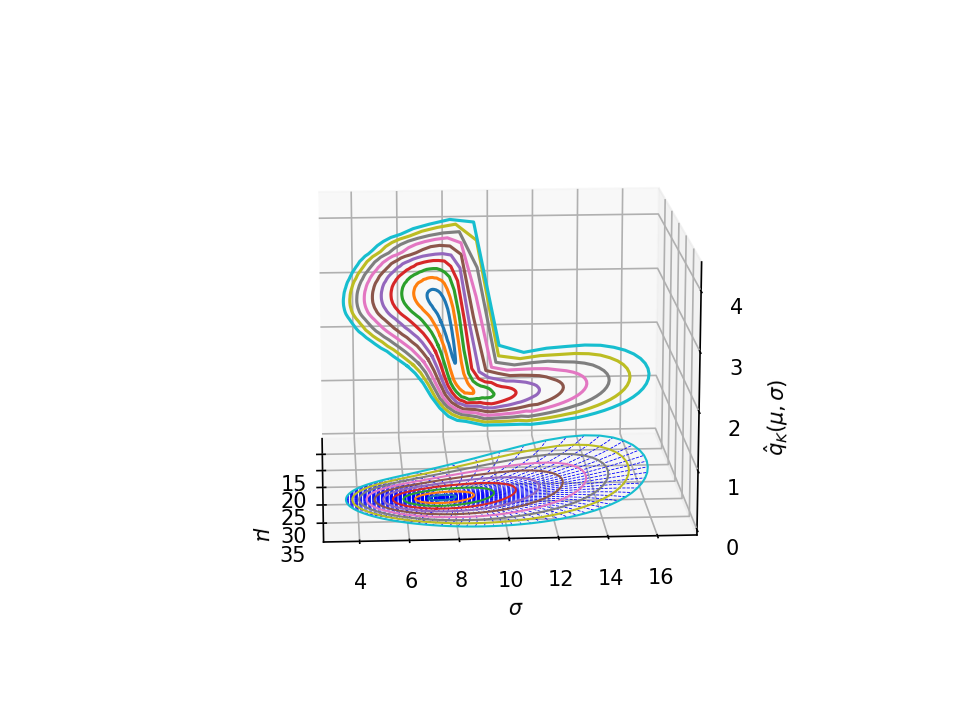

Text(0.5, 0, '$\\hat q_K(\\mu,\\sigma)$')

In [17]:
# Plotting in 3D the quantile estimator and the Fisher-Rao spheres of the truncated Gaussian
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Draws geodesics going from the center of the sphere
for i in range(nb_pts):
    X= Liste_Gauss_tr_sph[i][0]
    Y= Liste_Gauss_tr_sph[i][1]
    plt.plot(X,Y,color="blue",ls='--',linewidth = 0.4)

for i in range(nb_sphere):
    X_coord = Conctr_Gauss_sph[i][0]
    Y_coord = Conctr_Gauss_sph[i][1]
    plt.plot(X_coord,Y_coord,linewidth=1)
    #markerline_i, stemlines_i, baseline_i=ax.stem(Conctr_Gauss_sph[i][0],Conctr_Gauss_sph[i][1], quant_Gauss_val_sur_sph[i],markerfmt='-')
    #stemlines_i.set_color('green')
    #markerline_i.set_linewidth(2.5)
    
# Draws the value of the quantile estimator on the spheres
for i in range(nb_sphere):
    ax.plot(Conctr_Gauss_sph[i][0],Conctr_Gauss_sph[i][1], quant_Gauss_val_sur_sph[i])

#markerline.set_color('firebrick')

#ax.scatter(th0_Gauss[0],th0_Gauss[1],0,color='firebrick',marker=',')#,label = 'initial distribution')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$\hat q_K(\mu,\sigma)$')
#ax.set_title('Empirical quantile function on Fisher-Rao spheres');

<IPython.core.display.Javascript object>


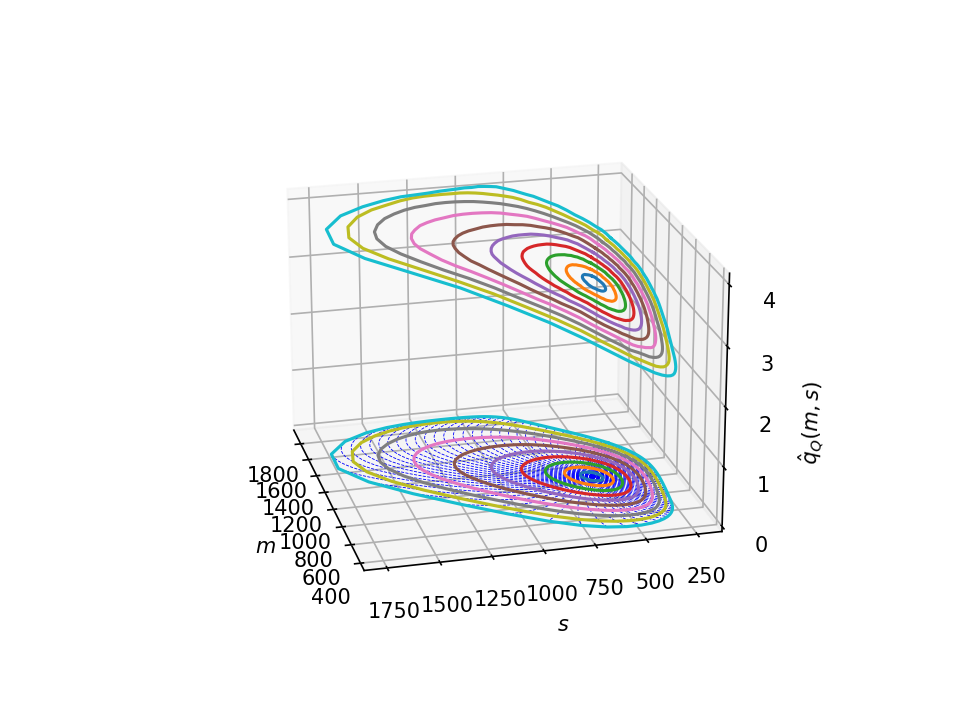

3.3209634984959986


In [18]:
# Plotting in 3D the quantile estimator and the Fisher-Rao spheres of the truncated Gaussian
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Draw geodesics going from the center of the sphere
for i in range(nb_pts):
    X= Liste_Gumb_tr_sph[i][0]
    Y= Liste_Gumb_tr_sph[i][1]
    plt.plot(X,Y,color="blue",ls='--',linewidth = 0.4)

for i in range(nb_sphere):
    plt.plot(Conctr_Gumb_sph[i][0],Conctr_Gumb_sph[i][1])
    
# Draw the value of the quantile estimator on the spheres
for i in range(nb_sphere):   
    ax.plot(Conctr_Gumb_sph[i][0],Conctr_Gumb_sph[i][1], quant_Gumb_val_sur_sph[i])

#ax.scatter(th0_Gumb[0],th0_Gumb[1],0,color='firebrick')#,label = 'initial distribution')
ax.set_xlabel('$m$')
ax.set_ylabel('$s$')
ax.set_zlabel('$\hat q_Q(m,s)$')
#ax.set_title('Empirical quantile function on Fisher-Rao spheres');
print(q_estim_init_Q)

### 5. Drawing the evolution of the PLI estimator as a function of $\delta$

In [80]:
Liste_argmin_K = []
Liste_argmax_K = []

Liste_argmin_Q = []
Liste_argmax_Q = []

Liste_argmin_Zm = []
Liste_argmax_Zm = []

Liste_argmin_Zv = []
Liste_argmax_Zv = []


Liste_val_min_K = []
Liste_val_max_K = []

Liste_val_min_Q = []
Liste_val_max_Q = []

Liste_val_min_Zm = []
Liste_val_max_Zm = []

Liste_val_min_Zv = []
Liste_val_max_Zv = []

    
for i in range(nb_sphere):
    # minimum and maximum values for the empirical quantile
    minimum_K,maximum_K = np.min(quant_Gauss_val_sur_sph[i]),np.max(quant_Gauss_val_sur_sph[i])    
    minimum_Q,maximum_Q = np.min(quant_Gumb_val_sur_sph[i]),np.max(quant_Gumb_val_sur_sph[i])
    minimum_Zm,maximum_Zm = np.min(quant_TriangZm_val_sur_sph[i]),np.max(quant_TriangZm_val_sur_sph[i])
    minimum_Zv,maximum_Zv = np.min(quant_TriangZv_val_sur_sph[i]),np.max(quant_TriangZv_val_sur_sph[i])
    
    # argmin and argmax points for the empirical quantile
    argmin_K,argmax_K = np.argmin(quant_Gauss_val_sur_sph[i]),np.argmax(quant_Gauss_val_sur_sph[i])    
    argmin_Q,argmax_Q = np.argmin(quant_Gumb_val_sur_sph[i]),np.argmax(quant_Gumb_val_sur_sph[i])
    argmin_Zm,argmax_Zm = np.argmin(quant_TriangZm_val_sur_sph[i]),np.argmax(quant_TriangZm_val_sur_sph[i])
    argmin_Zv,argmax_Zv = np.argmin(quant_TriangZv_val_sur_sph[i]),np.argmax(quant_TriangZv_val_sur_sph[i])
        
    # append each min and max values in a list for each input variable
    Liste_val_min_K.append(minimum_K)
    Liste_val_max_K.append(maximum_K)
    
    Liste_val_min_Q.append(minimum_Q)
    Liste_val_max_Q.append(maximum_Q)
    
    Liste_val_min_Zm.append(minimum_Zm)
    Liste_val_max_Zm.append(maximum_Zm)
    
    Liste_val_min_Zv.append(minimum_Zv)
    Liste_val_max_Zv.append(maximum_Zv)
    
    # append argmin and argmax points in a list for each input variable
    Liste_argmin_K.append(Conctr_Gauss_sph[i,:,argmin_K])
    Liste_argmax_K.append(Conctr_Gauss_sph[i,:,argmax_K])
    
    Liste_argmin_Q.append(Conctr_Gumb_sph[i,:,argmin_Q])
    Liste_argmax_Q.append(Conctr_Gumb_sph[i,:,argmax_Q])

    #Liste_argmin_Zm.append(Conctr_TriangZm_sph[i,argmin_Zm])
    #Liste_argmax_Zm.append(Conctr_TriangZm_sph[i,argmax_Zm])

    #Liste_argmin_Zv.append(Conctr_TriangZv_sph[i,argmin_Zv])
    #Liste_argmax_Zv.append(Conctr_TriangZv_sph[i,argmax_Zv])
    
    #Liste_min_K.append(list(theta_min_K))
    #Liste_max_K.append(list(theta_max_K))


In [81]:
for i in range(nb_sphere):
    #argument du minimum et maximum valeurs pour quantile empirique
    argmin_Zm,argmax_Zm = np.argmin(quant_TriangZm_val_sur_sph[i]),np.argmax(quant_TriangZm_val_sur_sph[i])
    argmin_Zv,argmax_Zv = np.argmin(quant_TriangZv_val_sur_sph[i]),np.argmax(quant_TriangZv_val_sur_sph[i])
        
     #append les points argmin et argmax dans une liste pour chaque entrée
    Liste_argmin_Zm.append(Conctr_TriangZm_sph[i][argmin_Zm])
    Liste_argmax_Zm.append(Conctr_TriangZm_sph[i][argmax_Zm])

    Liste_argmin_Zv.append(Conctr_TriangZv_sph[i][argmin_Zv])
    Liste_argmax_Zv.append(Conctr_TriangZv_sph[i][argmax_Zv])

In [82]:
Liste_val_min_K.insert(0,q_estim_init_K)
Liste_val_max_K.insert(0,q_estim_init_K)

Liste_val_min_Q.insert(0,q_estim_init_Q)
Liste_val_max_Q.insert(0,q_estim_init_Q)

Liste_val_min_Zm.insert(0,q_estim_init_Zm)
Liste_val_max_Zm.insert(0,q_estim_init_Zm)

Liste_val_min_Zv.insert(0,q_estim_init_Zv)
Liste_val_max_Zv.insert(0,q_estim_init_Zv)

<IPython.core.display.Javascript object>


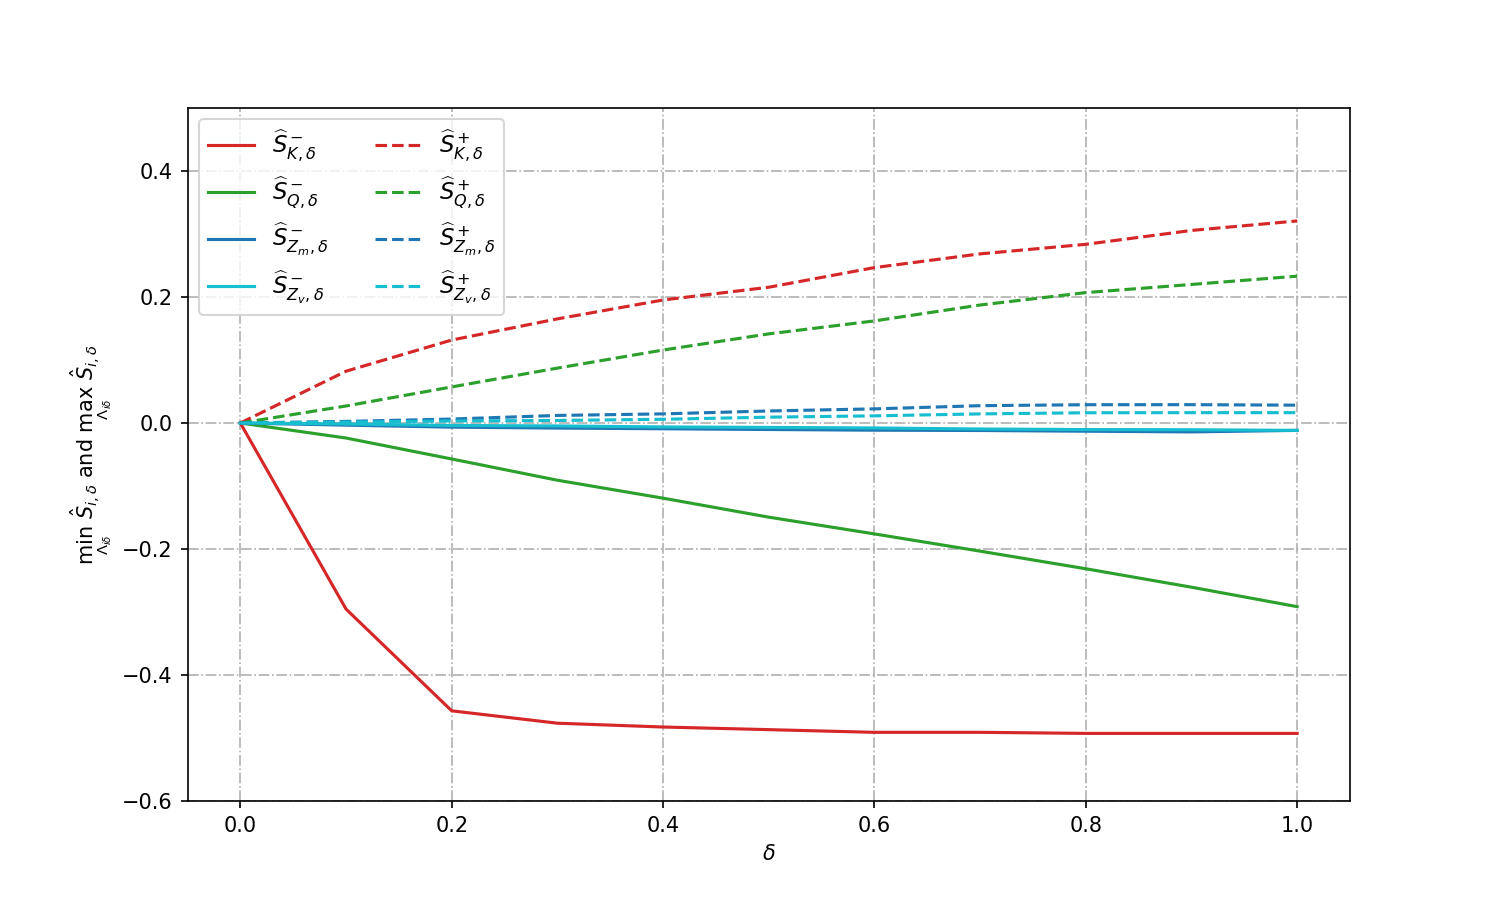

In [83]:
plt.figure(figsize=(10,6))    

plt.plot(np.arange(0,1.1,0.1),Liste_val_min_K/q_estim_init_K - np.ones(nb_sphere+1),color='#d62728',label ="$\widehat S_{K,\delta}^-$")
plt.plot(np.arange(0,1.1,0.1),Liste_val_min_Q/q_estim_init_Q - np.ones(nb_sphere+1),color='#2ca02c',label ="$\widehat S_{Q,\delta}^-$")
plt.plot(np.arange(0,1.1,0.1),Liste_val_min_Zm/q_estim_init_Zm - np.ones(nb_sphere+1),color='#1f77b4',label ="$\widehat S_{Z_m,\delta}^-$")
plt.plot(np.arange(0,1.1,0.1),Liste_val_min_Zv/q_estim_init_Zv - np.ones(nb_sphere+1),color='#17becf',label="$\widehat S_{Z_v,\delta}^-$")


plt.plot(np.arange(0,1.1,0.1),Liste_val_max_K/q_estim_init_K - np.ones(nb_sphere+1),color='#d62728',label ="$\widehat S_{K,\delta}^+$",ls='--')
plt.plot(np.arange(0,1.1,0.1),Liste_val_max_Q/q_estim_init_Q - np.ones(nb_sphere+1),color='#2ca02c',label ="$\widehat S_{Q,\delta}^+$",ls = '--')
plt.plot(np.arange(0,1.1,0.1),Liste_val_max_Zm/q_estim_init_Zm - np.ones(nb_sphere+1),color='#1f77b4',label ="$\widehat S_{Z_m,\delta}^+$",ls='--')
plt.plot(np.arange(0,1.1,0.1),Liste_val_max_Zv/q_estim_init_Zv - np.ones(nb_sphere+1),color='#17becf',label ="$\widehat S_{Z_v,\delta}^+$",ls='--')

plt.ylim(-0.6,0.5)
plt.xlabel('$\delta$')
plt.ylabel('$\min_{\Lambda_{i\delta}} \ \hat S_{i,\delta}$ and $\max_{\Lambda_{i\delta}} \ \hat S_{i,\delta}$')
plt.grid(linestyle="-.")
plt.legend(fontsize="11",loc="upper left",ncol=2);

Here, we will plot the argmin and argmax of each input variables' optimization problem.

<IPython.core.display.Javascript object>


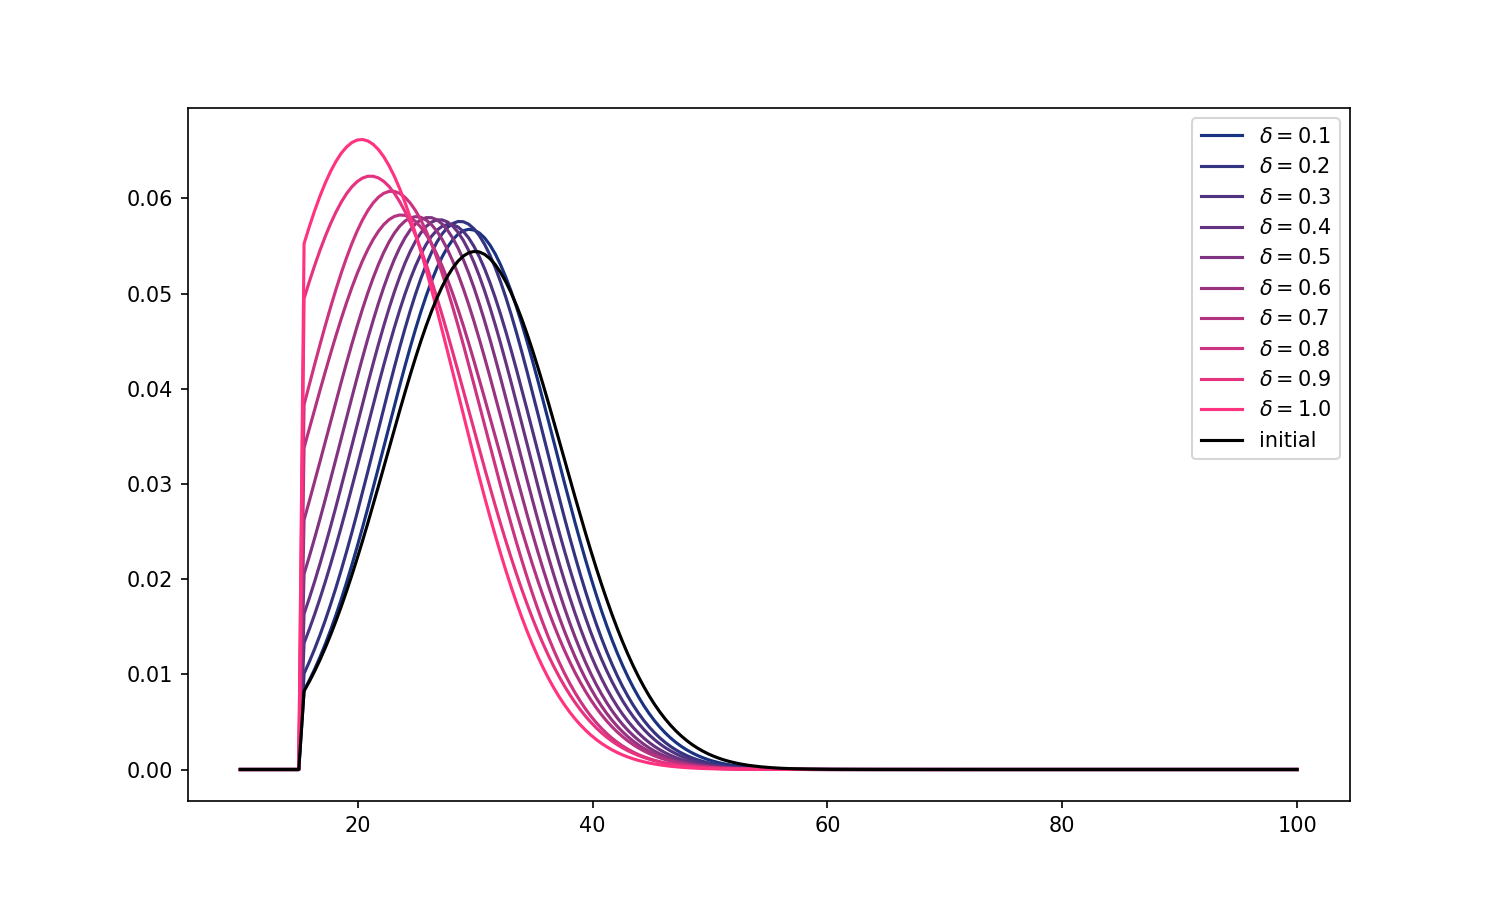

<class 'list'>


<IPython.core.display.Javascript object>


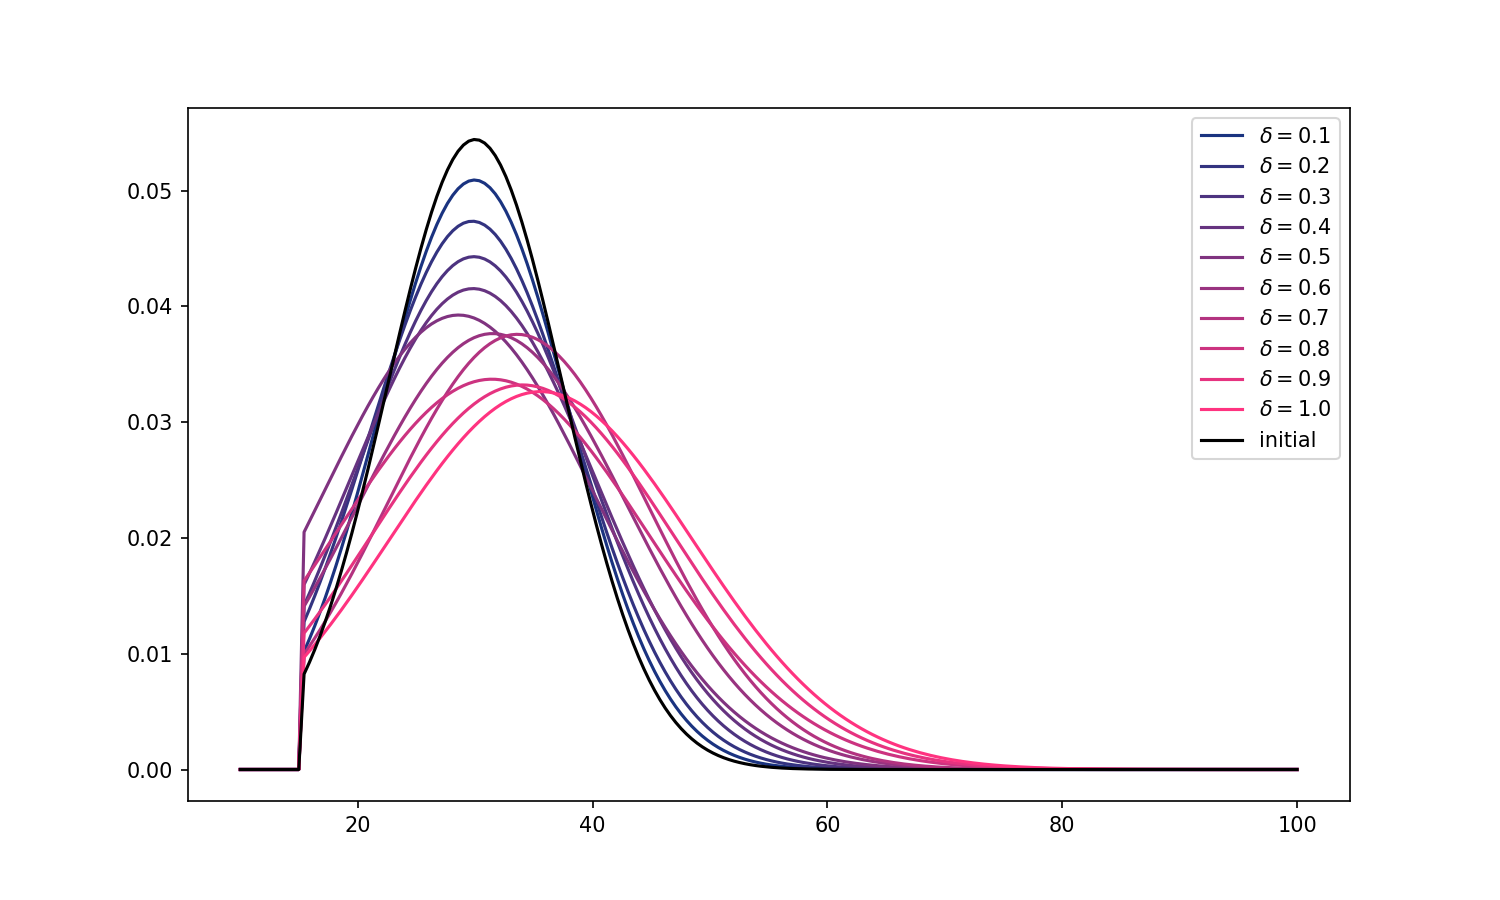

In [95]:
Line = np.linspace(10,100,200)
col_p = [(0.1, 0.2, 0.5),(0.1, 0.2, 0.5),(0.2, 0.2, 0.5),(0.3, 0.2, 0.5),(0.4, 0.2, 0.5),(0.5, 0.2, 0.5),(0.6, 0.2, 0.5),(0.7, 0.2, 0.5),(0.8, 0.2, 0.5),(0.9, 0.2, 0.5),(1.0, 0.2, 0.5)]

plt.figure(figsize=(10,6))
i = 1
for th in Liste_argmax_K:
    QQ = [trGauss.q(th[0],th[1],x,a_K,b_K) for x in Line]
    plt.plot(Line,QQ,label='$\delta=$'+str(i/10), color = col_p[i])
    i = i+1
QQQ = [trGauss.q(th0_Gauss[0],th0_Gauss[1],x,a_K,b_K) for x in Line]
print(type(QQQ))
plt.plot(Line,QQQ,label='initial',color='black')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
i = 1
for th in Liste_argmin_K:
    QQ = [trGauss.q(th[0],th[1],x,a_K,b_K) for x in Line]
    plt.plot(Line,QQ,label='$\delta=$'+str(i/10), color=col_p[i])
    i = i+1
QQQ = [trGauss.q(th0_Gauss[0],th0_Gauss[1],x,a_K,b_K) for x in Line]
plt.plot(Line,QQQ,label='initial',color='black')
plt.legend()

<IPython.core.display.Javascript object>


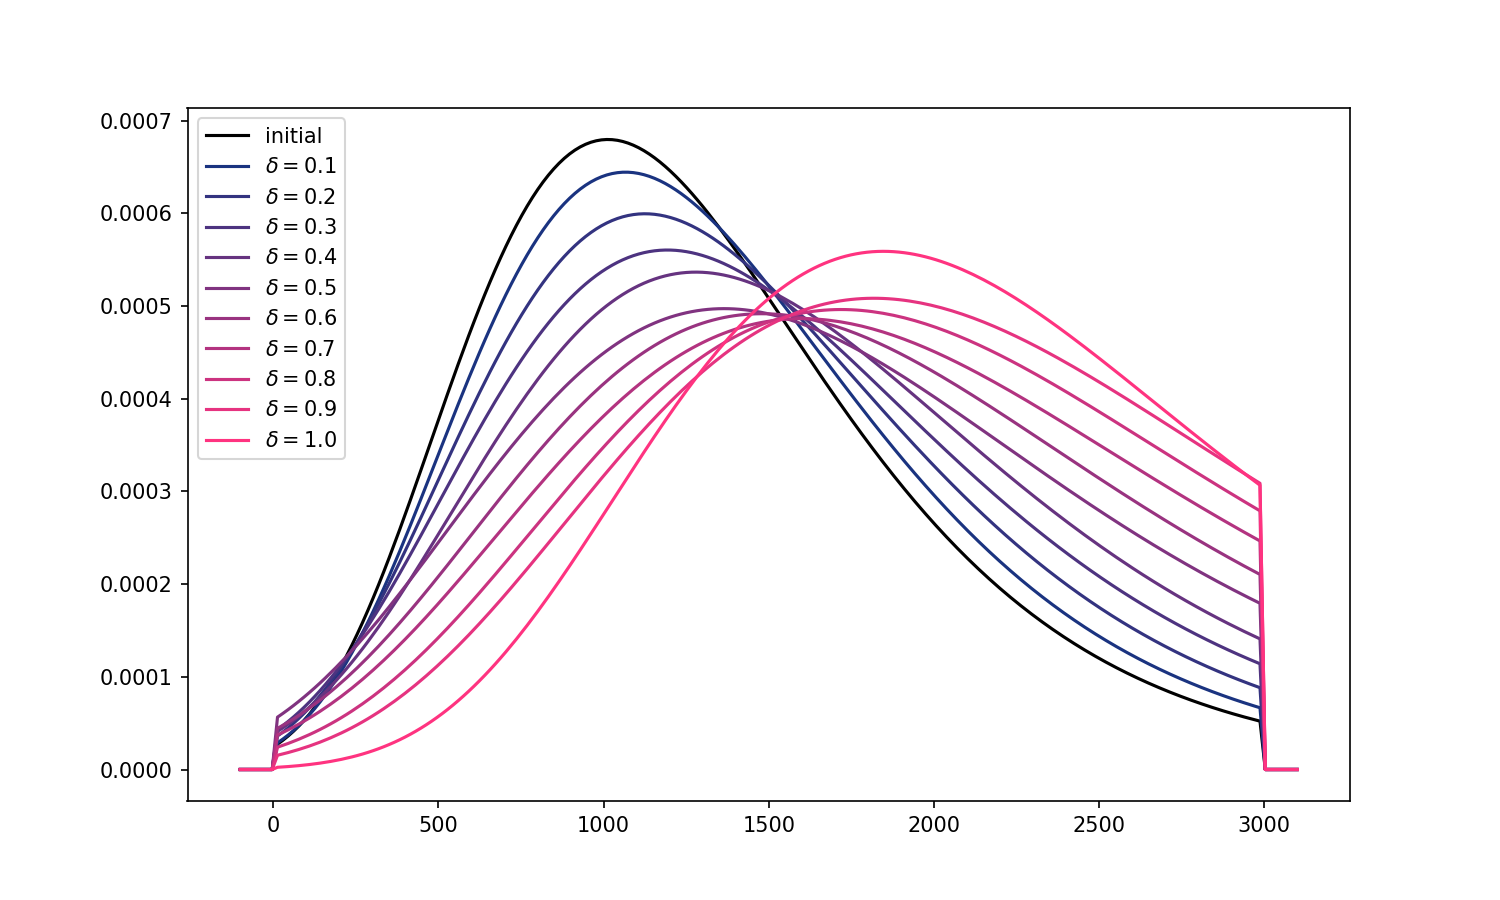

<IPython.core.display.Javascript object>


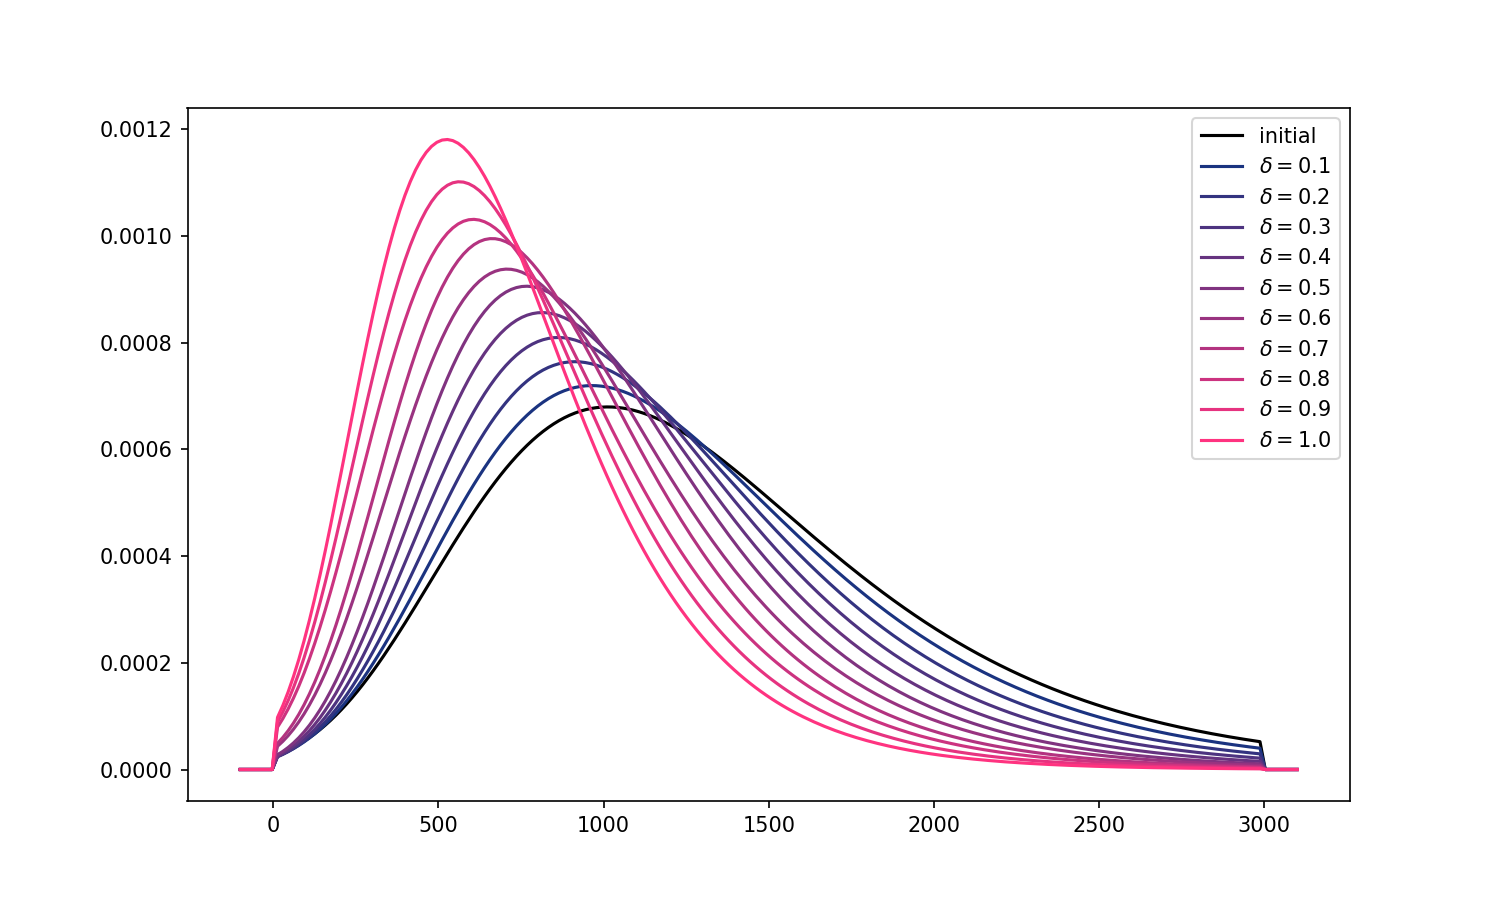

In [96]:
Line = np.linspace(-100,3100,200)
col_p = [(0.1, 0.2, 0.5),(0.1, 0.2, 0.5),(0.2, 0.2, 0.5),(0.3, 0.2, 0.5),(0.4, 0.2, 0.5),(0.5, 0.2, 0.5),(0.6, 0.2, 0.5),(0.7, 0.2, 0.5),(0.8, 0.2, 0.5),(0.9, 0.2, 0.5),(1.0, 0.2, 0.5)]

plt.figure(figsize=(10,6))
i = 1
QQQ = [trGumb.q(th0_Gumb[0],th0_Gumb[1],x,a_Q,b_Q) for x in Line]
plt.plot(Line,QQQ,label='initial',color='black')

for th in Liste_argmax_Q:
    QQ = [trGumb.q(th[0],th[1],x,a_Q,b_Q) for x in Line]
    plt.plot(Line,QQ,label='$\delta=$'+str(i/10), color = col_p[i])
    i = i+1
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
i = 1
QQQ = [trGumb.q(th0_Gumb[0],th0_Gumb[1],x,a_Q,b_Q) for x in Line]
plt.plot(Line,QQQ,label='initial',color='black')

for th in Liste_argmin_Q:
    QQ = [trGumb.q(th[0],th[1],x,a_Q,b_Q) for x in Line]
    plt.plot(Line,QQ,label='$\delta=$'+str(i/10), color = col_p[i])
    i = i+1
plt.legend()

<IPython.core.display.Javascript object>


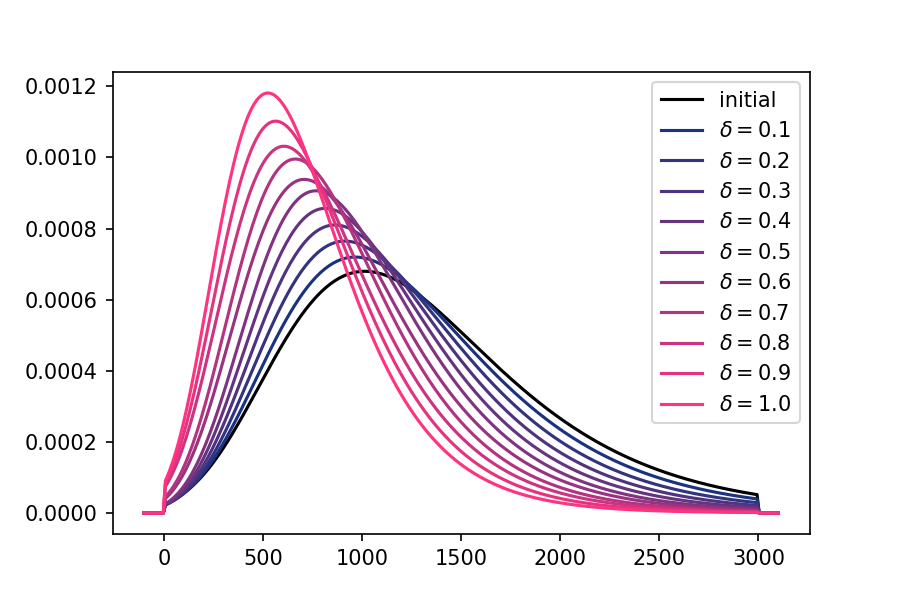

In [97]:
plt.figure(figsize=(6,4))
col_p = [(0.1, 0.2, 0.5),(0.1, 0.2, 0.5),(0.2, 0.2, 0.5),(0.3, 0.2, 0.5),(0.4, 0.2, 0.5),(0.5, 0.2, 0.5),(0.6, 0.2, 0.5),(0.7, 0.2, 0.5),(0.8, 0.2, 0.5),(0.9, 0.2, 0.5),(1.0, 0.2, 0.5)]

i = 1
Line = np.linspace(-100,3100,300)

QQQ = [trGumb.q(th0_Gumb[0],th0_Gumb[1],x,a_Q,b_Q) for x in Line]
plt.plot(Line,QQQ,label='initial',color='black')

for th in Liste_argmin_Q:
    QQ = [trGumb.q(th[0],th[1],x,a_Q,b_Q) for x in Line]
    plt.plot(Line,QQ,label='$\delta=$'+str(i/10), color = col_p[i])
    i = i+1
plt.legend()

### 6. Bootstrap for building confidence intervals

We want to build bootstrap confidence intervals for 
$$ \min_{f_{i\delta} \in \Lambda_{i\delta}} \widehat {S_{i\delta}}, $$

for $\delta \in \{0.1,0.2,...,1.0\}$ and $i=K,Q,Z_m,Z_v$. We approximated this value by
$$ \min_{f_{i\delta} \in \bar\Lambda_{i\delta}} \widehat {S_{i\delta}}, $$

where $\bar\Lambda_{i\delta}$ is a discretization of the Fisher-Rao sphere with 80 points. This second optimization problem can be solved by brute force
$$ \theta_{i\delta}^* \in  \text{argmin}_{f_{i\delta} \in \bar\Lambda_{i\delta}} \widehat {S_{i\delta}}, $$

where $\theta_{i\delta}^*\in \bar\Lambda_{i\delta}$ and

$$ \widehat {S_{i\delta}}(\theta_{i\delta}^*)=\min_{f_{i\delta} \in \bar\Lambda_{i\delta}} \widehat {S_{i\delta}}.$$

The function $\widehat {S_{i\delta}}$ is a statistic built on the initial sample $\mathcal H$ of the output $H$ of the flood model. Therefore to build the $80\%$ bootstrap confidence interval, we will resample $\mathcal H$ 10 times for each $\delta$ and for each $i$. We will do the same for the maximum.

In [29]:
def cdf_emp(Y_ord,t):
    B = Y_ord <= t*np.ones(len(Y_ord))
    return np.sum(B)/len(Y_ord)

def quant_emp(Y_ord,alpha):
    cdf = np.array([cdf_emp(Y_ord,t) for t in Y_ord])
    B = cdf <= alpha
    return np.sort(Y_ord)[np.sum(B) - 1]


def quantile_estim_fast(F_is,Sample_input,H_val,theta_0,theta,alpha,a,b):
    # order the H_val list
    H_val_ord = np.sort(H_val)
    
    i = int(alpha*len(H_val))
    
    # if the cdf is smaller than alpha on the ith element of the ordered sample H_val
    # we increment i
    
    if F_is(Sample_input,H_val,theta_0,theta,[H_val_ord[i]],a,b) < alpha:
        while F_is(Sample_input,H_val,theta_0,theta,[H_val_ord[i]],a,b) < alpha:
            i = i+1
        return H_val_ord[i-1] # the -1 is because of python's indexing convention

    # if the cdf is larger than alpha on the ith element of the ordered sample H_val
    # we decrement i
    else:
        while F_is(Sample_input,H_val,theta_0,theta,[H_val_ord[i]],a,b)>= alpha:
            i = i-1
        return H_val_ord[i] #again we use i instead of i-1 because of python's indexing convention


In [30]:
# Gaussian input K min
M = 100 # bootstrap samples

start = timeit.default_timer()

# Conf_interval_min_K is going to be a list containing the bootstrap confidence intervals
# for each delta in {0,0.1,0.2,...,1.0}. The first confidence interval (for delta=0) is [0,0]
# since the robustness index PLI is equal to 0."""

Conf_interval_min_K = [[0,0]]
for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap
    S = Liste_val_min_K[k+1]/q_estim_init_K - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGauss.quantile_estim_fast(trGauss.F_is,K_sample[U],H_val_resampled,th0_Gauss,Liste_argmin_K[k],0.9,a_K,b_K)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
    print(np.sort(delta_diff))
    
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_min_K.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for min K =",Conf_interval_min_K)

[-1.91718854e-02 -1.72062083e-02 -1.72062083e-02 -1.56258336e-02
 -1.56155807e-02 -1.44686691e-02 -1.25844765e-02 -1.25079549e-02
 -1.24060341e-02 -1.17042651e-02 -1.13205135e-02 -1.06930472e-02
 -9.77921927e-03 -9.64983645e-03 -9.58239866e-03 -9.19921874e-03
 -8.90980199e-03 -8.69870673e-03 -8.67066346e-03 -8.24637498e-03
 -7.48872708e-03 -7.46093839e-03 -7.28023382e-03 -7.24117209e-03
 -7.09249368e-03 -6.95517667e-03 -6.87131218e-03 -6.65187100e-03
 -6.59633705e-03 -6.29789549e-03 -5.57673131e-03 -5.07801209e-03
 -4.91278883e-03 -4.89449391e-03 -4.64603628e-03 -4.56121930e-03
 -4.21912558e-03 -4.20682212e-03 -4.07694798e-03 -4.05749542e-03
 -3.98141840e-03 -3.83799941e-03 -3.58424990e-03 -3.02230406e-03
 -2.75697882e-03 -2.75236096e-03 -2.60077167e-03 -2.12465696e-03
 -2.09401487e-03 -1.94789986e-03 -1.94490811e-03 -1.69867867e-03
 -1.60822897e-03 -1.46795211e-03 -1.32479402e-03 -1.21385922e-03
 -9.00047237e-04 -7.55433115e-04 -6.30028617e-04 -5.87188114e-04
 -2.34140680e-04  9.96371

[-0.03664814 -0.03225863 -0.0322314  -0.03170213 -0.03003373 -0.02860621
 -0.02840079 -0.02798934 -0.02761494 -0.02753495 -0.02718389 -0.02691695
 -0.02688474 -0.0265619  -0.01634834 -0.0159931  -0.01414034 -0.01402953
 -0.01346962 -0.0122045  -0.01087923 -0.00995483 -0.00966909 -0.00710678
 -0.00651931 -0.00648556 -0.00572779 -0.00540617 -0.00488774 -0.00479137
 -0.00381656 -0.00375775 -0.00331812 -0.00304681 -0.00300803 -0.00300803
 -0.00297328 -0.00249394 -0.00249394 -0.00236508 -0.00208376 -0.00184434
 -0.00182579 -0.00177221 -0.00141756 -0.00098015 -0.00086993 -0.00049873
 -0.00040271 -0.00032116 -0.00031263 -0.00015732  0.00012807  0.00012807
  0.00049457  0.0005632   0.0006704   0.00107503  0.00149625  0.00173778
  0.00173916  0.00220659  0.00224795  0.00330924  0.00330924  0.00336333
  0.00394989  0.0039854   0.0051434   0.0051508   0.00673374  0.00728638
  0.00763742  0.00845071  0.00899419  0.00909649  0.01032214  0.01118171
  0.0114802   0.01324977  0.01693619  0.01940639  0

In [31]:
# Gaussian input K max
M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_max_K = [[0,0]]
for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap
    S = Liste_val_max_K[k+1]/q_estim_init_K - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGauss.quantile_estim_fast(trGauss.F_is,K_sample[U],H_val_resampled,th0_Gauss,Liste_argmax_K[k],0.9,a_K,b_K)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
    print(np.sort(delta_diff))
    
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_max_K.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for max K =",Conf_interval_max_K)

[-1.22302902e-02 -1.02585551e-02 -9.60758231e-03 -9.07960019e-03
 -8.96851102e-03 -8.83774825e-03 -8.26055330e-03 -7.79492792e-03
 -7.56608426e-03 -7.10094896e-03 -6.99130240e-03 -6.04720454e-03
 -5.41801832e-03 -5.41403804e-03 -5.32475871e-03 -5.25215807e-03
 -5.21415029e-03 -5.17025617e-03 -4.63898472e-03 -4.62929885e-03
 -4.47573690e-03 -4.45138959e-03 -4.17320670e-03 -4.07692546e-03
 -3.95995399e-03 -3.81103133e-03 -3.75590059e-03 -3.54861605e-03
 -3.53499514e-03 -3.44665338e-03 -3.14117178e-03 -2.85000640e-03
 -2.70243129e-03 -2.63315101e-03 -2.60922141e-03 -2.51450724e-03
 -2.48699052e-03 -2.48477119e-03 -2.47874739e-03 -2.28048062e-03
 -2.06274938e-03 -2.02380296e-03 -1.99829618e-03 -1.83841435e-03
 -1.71190629e-03 -1.62263546e-03 -1.58172871e-03 -1.54071794e-03
 -1.49734233e-03 -1.47641923e-03 -1.45063432e-03 -1.37509778e-03
 -1.35753914e-03 -1.32324472e-03 -1.27043809e-03 -1.20608015e-03
 -1.17647133e-03 -1.05484004e-03 -8.18517913e-04 -6.73469401e-04
 -6.37396159e-04 -5.41053

[-0.02695923 -0.02673868 -0.02559473 -0.02524277 -0.02403437 -0.02385979
 -0.02298848 -0.0229406  -0.02288751 -0.0197235  -0.01787525 -0.01754742
 -0.01703658 -0.0169081  -0.01652002 -0.01605194 -0.01323279 -0.01293515
 -0.01286695 -0.01285709 -0.01230397 -0.01151982 -0.01026198 -0.00991154
 -0.00920347 -0.00889492 -0.00861686 -0.00851298 -0.0077338  -0.00761266
 -0.00697329 -0.00679595 -0.00651818 -0.00638249 -0.00573755 -0.00573043
 -0.0056913  -0.00507422 -0.00477227 -0.0046758  -0.00464413 -0.00371116
 -0.00363458 -0.00284167 -0.00247089 -0.00219004 -0.00203983 -0.00198762
 -0.00167405 -0.00161393 -0.00159703 -0.00159703 -0.00107581 -0.00106425
 -0.00102706 -0.00087814 -0.00084631 -0.00075029 -0.00072001 -0.00013224
  0.00012472  0.00088134  0.00124839  0.0013718   0.00156065  0.00170078
  0.00203822  0.00208098  0.00269534  0.00270017  0.00272012  0.00342791
  0.00363469  0.00387404  0.00445497  0.00471563  0.0052248   0.00569504
  0.00579192  0.00579528  0.00648022  0.00650371  0

In [32]:
# Gumbel input min Q

M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_min_Q = [[0,0]]

for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap
    S = Liste_val_min_Q[k+1]/q_estim_init_Q - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGumb.quantile_estim_fast(trGumb.F_is,Q_sample[U],H_val_resampled,th0_Gumb,Liste_argmin_Q[k],0.9,a_Q,b_Q)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
        
    print(np.sort(delta_diff))
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_min_Q.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for min Q =",Conf_interval_min_Q)

[-8.41196975e-03 -7.94146317e-03 -7.53049383e-03 -7.02423059e-03
 -6.05158574e-03 -5.93383186e-03 -5.88081488e-03 -5.56149673e-03
 -5.19775979e-03 -5.05209315e-03 -4.91228225e-03 -4.78558835e-03
 -4.44660511e-03 -4.44324195e-03 -4.29338251e-03 -4.25561417e-03
 -4.22215970e-03 -4.16050318e-03 -4.10794661e-03 -3.99264952e-03
 -3.91117876e-03 -3.77754223e-03 -3.77108661e-03 -3.67198664e-03
 -3.44702838e-03 -3.32963971e-03 -3.12753841e-03 -3.06082002e-03
 -2.99196966e-03 -2.85313049e-03 -2.78614882e-03 -2.75472850e-03
 -2.71389698e-03 -2.68240619e-03 -2.52746657e-03 -2.42422301e-03
 -2.39006461e-03 -2.35700448e-03 -2.34017626e-03 -2.29018929e-03
 -2.21240021e-03 -2.20232986e-03 -2.10149633e-03 -1.95969689e-03
 -1.95939517e-03 -1.57706101e-03 -1.56226244e-03 -1.53576074e-03
 -1.44795459e-03 -1.40224392e-03 -1.39050914e-03 -1.24950784e-03
 -1.18244682e-03 -1.16413954e-03 -9.89617304e-04 -8.77010307e-04
 -7.51156621e-04 -6.74562875e-04 -6.36318275e-04 -5.87538981e-04
 -5.43786767e-04 -4.56044

[-1.50159003e-02 -1.14971093e-02 -1.07249134e-02 -1.06917675e-02
 -9.54933113e-03 -9.18234514e-03 -8.39443274e-03 -6.74434169e-03
 -5.89608926e-03 -5.79941397e-03 -5.59900108e-03 -5.58048408e-03
 -5.38019699e-03 -5.19269047e-03 -5.02451018e-03 -5.00287150e-03
 -4.99122185e-03 -4.79763136e-03 -4.47377853e-03 -4.47369686e-03
 -4.45544895e-03 -4.23561806e-03 -4.18533295e-03 -3.92997788e-03
 -3.60473837e-03 -3.40793556e-03 -3.28963782e-03 -3.21981108e-03
 -3.15951217e-03 -2.86651687e-03 -2.33407134e-03 -1.15431253e-03
 -1.14836291e-03 -1.02212239e-03 -9.38144226e-04 -4.56310405e-04
 -1.80395424e-04 -1.21645397e-04  7.14988075e-05  8.46667108e-05
  2.86750495e-04  5.25356783e-04  5.72574442e-04  7.33829760e-04
  1.05319568e-03  1.09332634e-03  1.28280660e-03  1.31559216e-03
  1.62535938e-03  1.77315270e-03  1.77862173e-03  1.77931273e-03
  1.93342224e-03  1.99098835e-03  2.08301062e-03  2.30893141e-03
  2.38471397e-03  2.45784339e-03  2.65082283e-03  2.65670518e-03
  2.66946699e-03  2.81978

In [33]:
# Gumbel input max Q

M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_max_Q = [[0,0]]

for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap
    S = Liste_val_max_Q[k+1]/q_estim_init_Q - 1

    for j in range(M):
        # generate a uniform sample on {0,1,...,N} of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGumb.quantile_estim_fast(trGumb.F_is,Q_sample[U],H_val_resampled,th0_Gumb,Liste_argmax_Q[k],0.9,a_Q,b_Q)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
        
    print(np.sort(delta_diff))
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_max_Q.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for max Q =",Conf_interval_max_Q)

[-0.00827491 -0.00660014 -0.0059136  -0.00583976 -0.00548748 -0.00530417
 -0.00498809 -0.00459261 -0.00453449 -0.00420917 -0.00412243 -0.00383256
 -0.00382061 -0.00322462 -0.00312232 -0.00303493 -0.00285781 -0.00283316
 -0.00273397 -0.00269401 -0.00259516 -0.00252899 -0.00244316 -0.00240096
 -0.0023057  -0.00226104 -0.00223897 -0.00214907 -0.00210004 -0.00206644
 -0.00194168 -0.00187806 -0.00185167 -0.0016237  -0.00153213 -0.00152327
 -0.00148057 -0.00147384 -0.00146111 -0.00137598 -0.00137053 -0.00136768
 -0.00129217 -0.00125722 -0.00122534 -0.00118554 -0.00113497 -0.00109738
 -0.00108333 -0.00106778 -0.00106778 -0.00096035 -0.00091169 -0.00088164
 -0.00087713 -0.00078811 -0.00076568 -0.00055078 -0.00032065 -0.00025187
 -0.00024884 -0.00010699  0.00017723  0.00018933  0.00025358  0.00032231
  0.00042915  0.0004496   0.00062665  0.00067869  0.00080817  0.00085187
  0.00085449  0.00094196  0.00102246  0.00125169  0.00127499  0.00154468
  0.00161394  0.00173917  0.00188232  0.00194134  0

[-2.82849924e-02 -2.82849924e-02 -2.71227866e-02 -2.64697829e-02
 -2.30698716e-02 -2.15691913e-02 -2.14886519e-02 -1.89989824e-02
 -1.89654867e-02 -1.87667630e-02 -1.78188428e-02 -1.74237827e-02
 -1.74140745e-02 -1.60750776e-02 -1.57578811e-02 -1.47849203e-02
 -1.38921595e-02 -1.36196914e-02 -1.23315693e-02 -1.21964408e-02
 -1.21550189e-02 -1.18555603e-02 -1.12572586e-02 -9.87195622e-03
 -9.54488495e-03 -9.16186694e-03 -8.85817477e-03 -8.56625060e-03
 -8.45309929e-03 -8.15075558e-03 -8.00870453e-03 -7.89728279e-03
 -7.67464614e-03 -7.21019324e-03 -7.19867456e-03 -7.02957133e-03
 -6.73740810e-03 -5.99101103e-03 -5.89545901e-03 -5.32768199e-03
 -5.14162583e-03 -4.97125618e-03 -3.73512439e-03 -3.64723828e-03
 -3.63415237e-03 -3.58040411e-03 -3.45735158e-03 -2.99763307e-03
 -2.89177009e-03 -2.25763870e-03 -1.71913345e-03 -1.65727584e-03
 -1.51018012e-03 -1.42307129e-03 -1.11590395e-03 -9.13724789e-04
 -6.85462664e-04 -6.80869610e-04 -6.74424554e-04 -1.75918614e-04
 -1.19622797e-04  3.74279

In [84]:
# Triangular input min Zm

M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_min_Zm = [[0,0]]

for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap (evaluated on k+1 since the first element of the list
    #is 0)
    S = Liste_val_min_Zm[k+1]/q_estim_init_Zm - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = quantile_estim_fast(trTriang.F_is,Zm_sample[U],H_val_resampled,th0_Zm,Liste_argmin_Zm[k],0.9,a_Zm,b_Zm)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
        
    print(np.sort(delta_diff))
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_min_Zm.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for min Zm =",Conf_interval_min_Zm)

[-3.87900992e-03 -3.28503509e-03 -3.26123580e-03 -3.21813092e-03
 -2.58037502e-03 -2.44695733e-03 -2.31436437e-03 -2.20611195e-03
 -2.17722386e-03 -2.04724736e-03 -1.68519265e-03 -1.62154217e-03
 -1.60117806e-03 -1.55625145e-03 -1.54612705e-03 -1.50831774e-03
 -1.44261102e-03 -1.33687493e-03 -1.25577245e-03 -1.22279648e-03
 -9.86164284e-04 -9.85199423e-04 -9.76599522e-04 -9.15164840e-04
 -9.04824832e-04 -8.15027528e-04 -7.84159218e-04 -7.42915706e-04
 -7.06456177e-04 -6.64924216e-04 -5.87049959e-04 -3.57223836e-04
 -3.21194763e-04 -3.11883392e-04 -3.11883392e-04 -2.95121031e-04
 -2.41759650e-04 -2.41451970e-04 -2.38711838e-04 -2.04518060e-04
 -1.99281919e-04 -1.52845795e-04 -1.38428350e-04 -1.38383974e-04
 -3.07517007e-05  1.54570662e-05  8.92607030e-05  1.34368327e-04
  1.91500243e-04  1.91500243e-04  2.22139917e-04  2.24494693e-04
  2.28672769e-04  2.67854274e-04  2.89038022e-04  3.78583427e-04
  3.86271936e-04  4.13673925e-04  4.49087829e-04  4.67303077e-04
  4.79639114e-04  4.92087

[-1.62567032e-02 -1.44797117e-02 -1.08694109e-02 -9.92464036e-03
 -9.81041671e-03 -9.71598205e-03 -9.46227530e-03 -8.56768993e-03
 -8.14496263e-03 -7.95083100e-03 -7.76038191e-03 -7.54323587e-03
 -7.46351686e-03 -7.09756057e-03 -6.91765450e-03 -6.87151197e-03
 -6.58966543e-03 -6.57431700e-03 -6.21107846e-03 -5.95818017e-03
 -5.94078395e-03 -5.69138995e-03 -4.89461711e-03 -4.85186623e-03
 -4.83038344e-03 -4.81032983e-03 -4.75280473e-03 -4.63306099e-03
 -4.25440364e-03 -4.18537886e-03 -3.59653872e-03 -3.52771386e-03
 -3.42232895e-03 -3.42198762e-03 -3.41919283e-03 -3.09125915e-03
 -2.83571423e-03 -2.80620451e-03 -2.65349589e-03 -2.62125823e-03
 -2.40226722e-03 -2.15004424e-03 -2.00819280e-03 -1.82741193e-03
 -1.72594078e-03 -1.71140833e-03 -1.40593609e-03 -1.24334554e-03
 -1.23015027e-03 -6.70822016e-04 -6.15983598e-04 -4.56365382e-04
 -4.40468183e-04 -3.50620396e-04 -1.61114119e-04 -1.33739404e-04
 -8.19003588e-05 -8.19003588e-05 -5.64839366e-05  6.95732996e-05
  1.49482368e-04  1.79319

In [85]:
# Triangular input max Zm

M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_max_Zm = [[0,0]]

for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap (evaluated on k+1 since the first element of the list
    #is 0)
    S = Liste_val_max_Zm[k+1]/q_estim_init_Zm - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGumb.quantile_estim_fast(trTriang.F_is,Zm_sample[U],H_val_resampled,th0_Zm,Liste_argmax_Zm[k],0.9,a_Zm,b_Zm)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
        
    print(np.sort(delta_diff))
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_max_Zm.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for max Zm =",Conf_interval_max_Zm)

[-2.09812303e-03 -2.07155317e-03 -2.05008965e-03 -1.91180738e-03
 -1.76291058e-03 -1.60952229e-03 -1.52790085e-03 -1.46281510e-03
 -1.45230754e-03 -1.45087431e-03 -1.41247211e-03 -1.27372680e-03
 -1.20716077e-03 -1.18093672e-03 -1.16299938e-03 -1.13409774e-03
 -9.49635274e-04 -9.27172701e-04 -9.08494764e-04 -8.32584014e-04
 -7.87845224e-04 -7.42850175e-04 -7.07879077e-04 -5.58460481e-04
 -5.16017872e-04 -5.02413930e-04 -4.72515143e-04 -4.64690772e-04
 -4.59307673e-04 -3.72144002e-04 -2.94490779e-04 -1.57849025e-04
 -1.19085017e-04 -1.19085017e-04 -1.16337924e-04 -1.09318800e-04
 -9.46795619e-05 -6.19738775e-05 -4.18976572e-05 -3.49912618e-05
  0.00000000e+00  5.09054957e-06  1.49229450e-04  1.56052784e-04
  1.79739224e-04  1.94596778e-04  2.71011740e-04  3.19522047e-04
  3.23721524e-04  3.55511905e-04  4.40775764e-04  4.60584306e-04
  5.19531190e-04  5.19531190e-04  5.74495721e-04  5.85373727e-04
  6.21542257e-04  6.24058380e-04  6.75780742e-04  6.93206268e-04
  7.18141355e-04  7.18141

[-0.01813407 -0.01285085 -0.01211047 -0.01063817 -0.01003911 -0.00939342
 -0.00934489 -0.00871361 -0.00861396 -0.0076458  -0.00761816 -0.00752872
 -0.00751401 -0.00705877 -0.00648063 -0.00643926 -0.00627481 -0.00590334
 -0.00583969 -0.00518177 -0.0050275  -0.00481571 -0.00475224 -0.00459998
 -0.00396872 -0.00375599 -0.00372124 -0.00363862 -0.00339711 -0.00303244
 -0.00280739 -0.00246874 -0.00235087 -0.00213629 -0.00211014 -0.00199754
 -0.00188675 -0.00172857 -0.00143451 -0.00137141 -0.00132626 -0.00129377
 -0.0012587  -0.00113436 -0.00104997 -0.00091798 -0.00069342 -0.00055612
 -0.00033664 -0.00032128  0.00021157  0.00069375  0.00071238  0.00078449
  0.00079584  0.00086268  0.00108816  0.00137177  0.0016903   0.00169594
  0.00177899  0.00184616  0.00243988  0.00249373  0.0025624   0.00258252
  0.00275363  0.00292231  0.00311713  0.00322153  0.00328993  0.0033559
  0.00337584  0.00344346  0.0039396   0.00395321  0.00395464  0.00420857
  0.00429095  0.00448611  0.00479403  0.00501693  0.

In [86]:
# Triangular input min Zv

M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_min_Zv = [[0,0]]

for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap (evaluated on k+1 since the first element of the list
    #is 0)
    S = Liste_val_min_Zv[k+1]/q_estim_init_Zv - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGumb.quantile_estim_fast(trTriang.F_is,Zv_sample[U],H_val_resampled,th0_Zv,Liste_argmin_Zv[k],0.9,a_Zv,b_Zv)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
        
    print(np.sort(delta_diff))
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_min_Zv.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for min Zv =",Conf_interval_min_Zv)

[-3.53951037e-03 -2.96630103e-03 -2.44295627e-03 -2.38583371e-03
 -2.24140670e-03 -2.14704469e-03 -2.05991753e-03 -1.80701747e-03
 -1.70558234e-03 -1.68953590e-03 -1.66147164e-03 -1.64360281e-03
 -1.63218257e-03 -1.55065932e-03 -1.52377968e-03 -1.50404390e-03
 -1.48783371e-03 -1.44715286e-03 -1.39583244e-03 -1.19635177e-03
 -1.18025198e-03 -1.07876882e-03 -1.07686576e-03 -1.02621636e-03
 -9.19091248e-04 -8.94376515e-04 -8.92645213e-04 -8.82212025e-04
 -8.29284331e-04 -8.29284331e-04 -8.01287413e-04 -6.25265054e-04
 -6.11805665e-04 -6.05235656e-04 -5.92176454e-04 -5.78556728e-04
 -5.23070333e-04 -5.07682524e-04 -4.08632387e-04 -4.08508459e-04
 -3.58676814e-04 -3.06223913e-04 -3.02604188e-04 -2.13703768e-04
 -1.98157755e-04 -1.97467414e-04 -1.84056451e-04 -1.82804994e-04
 -1.63347897e-04 -1.47502149e-04 -1.42260140e-04 -1.06264362e-04
 -9.50824156e-05 -8.19938202e-05 -3.81042190e-05  0.00000000e+00
  1.22618636e-05  2.26496069e-05  2.26496069e-05  6.10865327e-05
  1.02686126e-04  1.03668

[-9.55295095e-03 -8.88596684e-03 -8.64234383e-03 -8.62224484e-03
 -7.88756301e-03 -7.47989786e-03 -7.13913584e-03 -6.84096987e-03
 -6.80041551e-03 -6.55195545e-03 -6.47592652e-03 -6.27883019e-03
 -6.19509903e-03 -5.98241601e-03 -5.64296401e-03 -5.59471333e-03
 -5.49312341e-03 -5.16119933e-03 -4.90405231e-03 -4.77183793e-03
 -4.50053360e-03 -4.04752765e-03 -4.03064693e-03 -3.75326654e-03
 -3.70928396e-03 -3.66015281e-03 -3.16376446e-03 -2.99797822e-03
 -2.85524725e-03 -2.75490014e-03 -2.57568352e-03 -2.52534886e-03
 -2.14353367e-03 -1.78996261e-03 -1.49986516e-03 -1.48868320e-03
 -1.48127129e-03 -1.43310081e-03 -1.43310081e-03 -1.31227942e-03
 -1.17030313e-03 -1.00330172e-03 -9.70439778e-04 -7.88825587e-04
 -1.95899999e-04 -1.63933775e-04 -8.14777266e-06  2.40477318e-04
  2.74947308e-04  3.86050901e-04  5.82272716e-04  5.89706911e-04
  7.41527764e-04  7.54481909e-04  7.92474082e-04  8.54673008e-04
  8.60212429e-04  8.82230846e-04  1.00003306e-03  1.03807969e-03
  1.58624503e-03  1.58835

In [87]:
# Triangular input max Zv

M = 100 # bootstrap samples

start = timeit.default_timer()
Conf_interval_max_Zv = [[0,0]]

for k in range(10):
    delta_diff = []
    
    #the initial value of the statistic before bootstrap (evaluated on k+1 since the first element of the list
    #is 0)
    S = Liste_val_max_Zv[k+1]/q_estim_init_Zv - 1

    for j in range(M):
        # generate a uniform integer sample on [0,N] of size N
        U = np.random.randint(N, size=N)

        # define the bootstrap sample
        H_val_resampled = H_val[U]

        #compute the statistic on the bootstrap sample
        q_th_star_RIS = trGumb.quantile_estim_fast(trTriang.F_is,Zv_sample[U],H_val_resampled,th0_Zv,Liste_argmax_Zv[k],0.9,a_Zv,b_Zv)
        q_th0_star = quant_emp(H_val_resampled,alpha)
        S_star = q_th_star_RIS/q_th0_star - 1
        
        #append the difference to a list
        delta_diff.append(S_star - S)
        
    print(np.sort(delta_diff))
    l_bound,u_bound = S - np.sort(delta_diff)[int(0.9*M)], S - np.sort(delta_diff)[int(0.1*M)]
    Conf_interval_max_Zv.append([l_bound,u_bound])
stop = timeit.default_timer()

print(stop - start, "seconds")
print("")
print("Conf intervals for max Zv =",Conf_interval_max_Zv)

[-1.31570450e-03 -1.31570450e-03 -1.25268385e-03 -1.18789560e-03
 -1.14449618e-03 -1.06866616e-03 -9.82217233e-04 -9.39918082e-04
 -9.37845394e-04 -8.89714051e-04 -8.89714051e-04 -8.67936349e-04
 -8.64824898e-04 -8.00160147e-04 -7.70248748e-04 -7.58387535e-04
 -7.36809242e-04 -7.07175848e-04 -6.37296012e-04 -6.15011322e-04
 -6.07112210e-04 -6.00542551e-04 -4.87112871e-04 -4.86458604e-04
 -4.68477226e-04 -4.65971539e-04 -4.61143013e-04 -4.54585307e-04
 -4.29884311e-04 -4.29884311e-04 -4.15408401e-04 -4.12604573e-04
 -3.93940410e-04 -3.81922383e-04 -3.06929211e-04 -2.42385632e-04
 -2.27160441e-04 -1.88547580e-04 -1.76439059e-04 -1.42783988e-04
 -1.13809851e-04 -1.12156989e-04 -9.24289162e-05 -6.12907571e-05
 -3.70811375e-05 -1.88586979e-05 -4.93400496e-06  3.29013191e-05
  6.36514983e-05  8.38202999e-05  1.26991730e-04  1.41796691e-04
  1.80583593e-04  2.56397388e-04  2.70793643e-04  3.70891973e-04
  3.94850869e-04  4.60625812e-04  4.89564964e-04  6.06559064e-04
  6.37307918e-04  6.40911

[-1.44517147e-02 -1.44517147e-02 -1.38399947e-02 -1.26084158e-02
 -1.18807070e-02 -1.11403132e-02 -1.06374134e-02 -1.02583638e-02
 -1.02111374e-02 -9.52523484e-03 -9.34798734e-03 -9.28884357e-03
 -8.65648219e-03 -8.47977011e-03 -7.57782315e-03 -7.33607174e-03
 -7.24492956e-03 -6.24890582e-03 -5.75183530e-03 -5.50753115e-03
 -5.26092752e-03 -5.24302221e-03 -5.04539827e-03 -4.96900543e-03
 -4.69824280e-03 -4.48314125e-03 -4.28420896e-03 -4.26784060e-03
 -4.25998878e-03 -4.25465284e-03 -4.04109988e-03 -3.85690408e-03
 -3.83203040e-03 -3.54882433e-03 -3.12630528e-03 -3.00217150e-03
 -2.74559207e-03 -2.74559207e-03 -2.74155364e-03 -2.71586226e-03
 -2.50468619e-03 -2.37312002e-03 -2.31074028e-03 -1.69874491e-03
 -1.59039026e-03 -1.57780777e-03 -1.46243394e-03 -1.40709054e-03
 -1.38871969e-03 -1.32180872e-03 -1.21405372e-03 -1.11793015e-03
 -1.00453838e-03 -8.21373724e-04 -8.10277190e-04 -4.54729897e-04
 -7.41549723e-05  2.05950495e-04  2.35443838e-04  2.70148437e-04
  3.72341850e-04  4.86782

In [88]:
#Here we convert the list of the confidence intervals into arrays


Conf_interval_min_K_arr = np.array(Conf_interval_min_K)
Conf_interval_max_K_arr = np.array(Conf_interval_max_K)
Conf_interval_min_Q_arr = np.array(Conf_interval_min_Q)
Conf_interval_max_Q_arr = np.array(Conf_interval_max_Q)

Conf_interval_min_Zm_arr = np.array(Conf_interval_min_Zm)
Conf_interval_max_Zm_arr = np.array(Conf_interval_max_Zm)
Conf_interval_min_Zv_arr = np.array(Conf_interval_min_Zv)
Conf_interval_max_Zv_arr = np.array(Conf_interval_max_Zv)


<IPython.core.display.Javascript object>


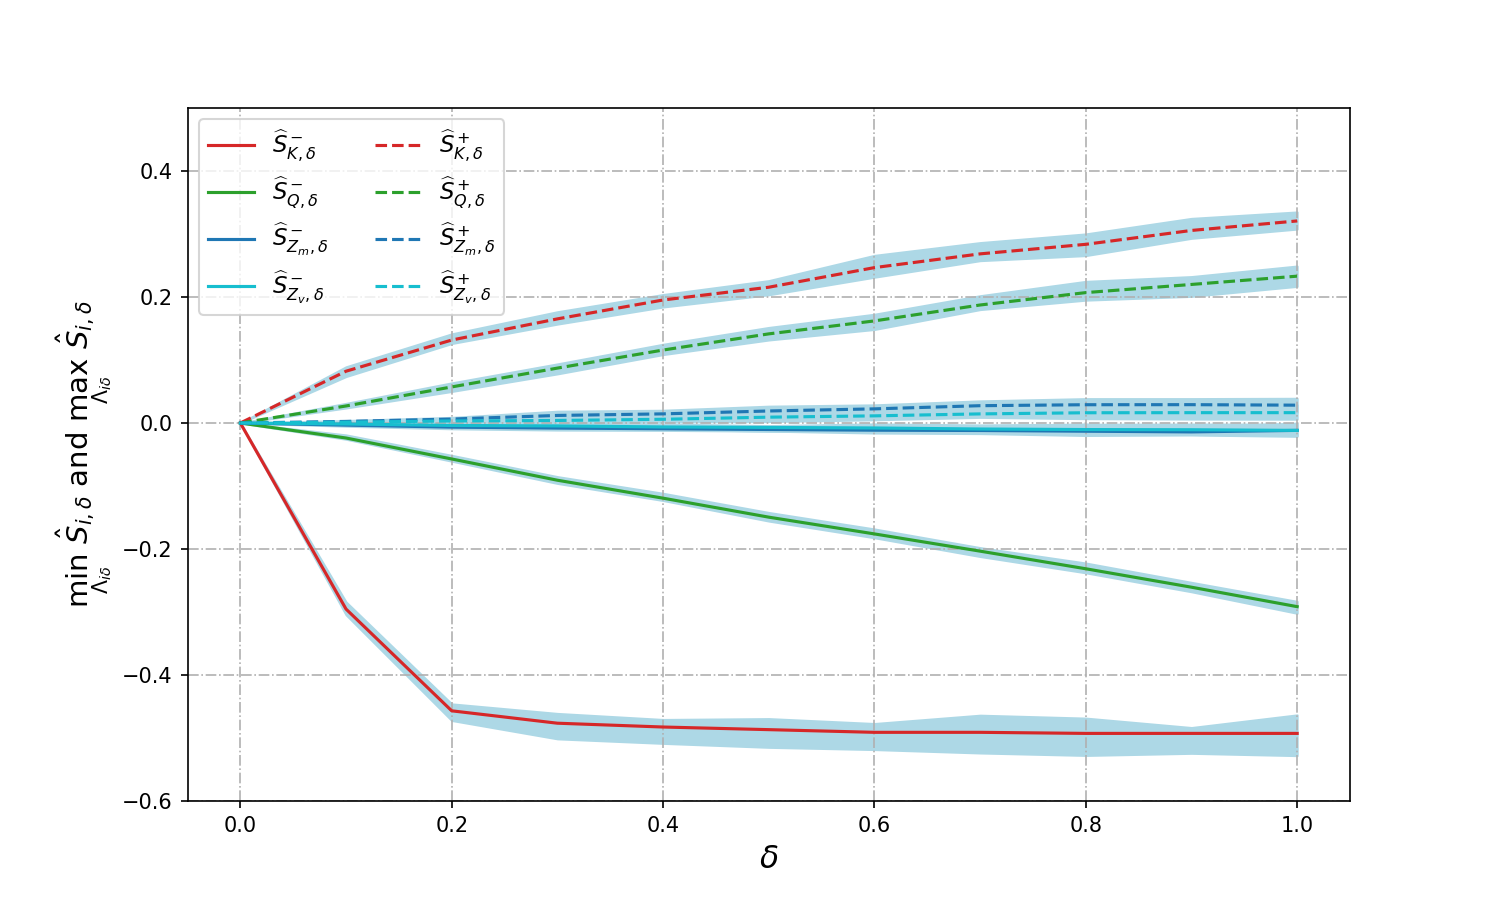

In [91]:
# Here we plot the confidence intervals
plt.figure(figsize=(10,6))    

plt.plot(np.arange(0,1.1,0.1),Liste_val_min_K/q_estim_init_K - np.ones(nb_sphere+1),color='tab:red',label ="$\widehat S_{K,\delta}^-$")
plt.plot(np.arange(0,1.1,0.1),Liste_val_min_Q/q_estim_init_Q - np.ones(nb_sphere+1),color='tab:green',label ="$\widehat S_{Q,\delta}^-$")
plt.plot(np.arange(0,1.1,0.1),Liste_val_min_Zm/q_estim_init_Zm - np.ones(nb_sphere+1),color='#1f77b4',label ="$\widehat S_{Z_m,\delta}^-$")
plt.plot(np.arange(0,1.1,0.1),Liste_val_min_Zv/q_estim_init_Zv - np.ones(nb_sphere+1),color='#17becf',label="$\widehat S_{Z_v,\delta}^-$")

plt.plot(np.arange(0,1.1,0.1),Liste_val_max_K/q_estim_init_K - np.ones(nb_sphere+1),color='tab:red',label ="$\widehat S_{K,\delta}^+$",ls='--')
plt.plot(np.arange(0,1.1,0.1),Liste_val_max_Q/q_estim_init_Q - np.ones(nb_sphere+1),color='tab:green',label ="$\widehat S_{Q,\delta}^+$",ls = '--')
plt.plot(np.arange(0,1.1,0.1),Liste_val_max_Zm/q_estim_init_Zm - np.ones(nb_sphere+1),color='#1f77b4',label ="$\widehat S_{Z_m,\delta}^+$",ls='--')
plt.plot(np.arange(0,1.1,0.1),Liste_val_max_Zv/q_estim_init_Zv - np.ones(nb_sphere+1),color='#17becf',label ="$\widehat S_{Z_v,\delta}^+$",ls='--')


plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_min_K_arr[:,0],Conf_interval_min_K_arr[:,1],color = 'lightblue')#,label='80% bootstrap CI')
plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_max_K_arr[:,0],Conf_interval_max_K_arr[:,1],color = 'lightblue')
plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_min_Q_arr[:,0],Conf_interval_min_Q_arr[:,1],color = 'lightblue')
plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_max_Q_arr[:,0],Conf_interval_max_Q_arr[:,1],color = 'lightblue')

plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_min_Zm_arr[:,0],Conf_interval_min_Zm_arr[:,1],color = 'lightblue')
plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_max_Zm_arr[:,0],Conf_interval_max_Zm_arr[:,1],color = 'lightblue')
plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_min_Zv_arr[:,0],Conf_interval_min_Zv_arr[:,1],color = 'lightblue')
plt.fill_between(np.arange(0,1.1,0.1),Conf_interval_max_Zv_arr[:,0],Conf_interval_max_Zv_arr[:,1],color = 'lightblue')

plt.ylim(-0.6,0.5)
plt.xlabel('$\delta$',size='15')
plt.ylabel('$\min_{\Lambda_{i\delta}} \ \hat S_{i,\delta}$ and $\max_{\Lambda_{i\delta}} \ \hat S_{i,\delta}$',size='14')
plt.grid(linestyle="-.")
plt.legend(fontsize="11",loc="upper left",ncol=2);